In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement= Base.classes.measurement
Station= Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)
2017-08-23 00:00:00
2016-08-23


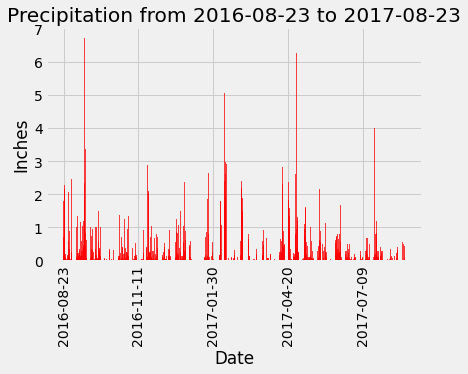

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lastdate_ts = dt.datetime.strptime(lastdate[0], '%Y-%m-%d')   #_ts(time stamp)
print(lastdate)
print(lastdate_ts)
yearb4_lastdate_ts = dt.date(lastdate_ts.year -1, lastdate_ts.month, lastdate_ts.day)
print(yearb4_lastdate_ts)

# Perform a query to retrieve the data and precipitation scores
queryresult = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= yearb4_lastdate_ts).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip = pd.DataFrame(queryresult)

precip = precip.set_index("date")
precip
# Sort the dataframe by date

precip=precip.sort_values(by=['date'])
precip

# Use Pandas Plotting with Matplotlib to plot the data
x = precip.index.tolist()
y = precip['prcp'].tolist()

plt.bar(x, y, color='red', alpha=0.75, align="center",label='Precipitation')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title(f"Precipitation from {yearb4_lastdate_ts} to {lastdate[0]}")
plt.grid(which='major', axis='both', linestyle='-')
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks,rotation='vertical')
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_statn=session.query(Measurement.station, func.count(Measurement.id))\
                    .group_by(Measurement.station)\
                    .order_by(func.count(Measurement.id).desc()).all()
active_statn
active_statn_df=pd.DataFrame(active_statn, columns=['Station','Count of temp'])
active_statn_df

,Station,Count of temp
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_statn_temp=session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                    .group_by(Measurement.station)\
                    .order_by(func.count(Measurement.id).desc()).first()
active_statn_temp

('USC00519281', 54.0, 85.0, 71.66378066378067)

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# getting the tobs values for active_statn[0][0] into a list temps
query = session.query(Measurement.tobs)\
                .filter(Measurement.station == active_statn[0][0])\
                .filter(Measurement.date >= yearb4_lastdate_ts).all()
temps = list(np.ravel(query))

# getting the station name for active_statn[0][0] 
queryresult = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

station_name = stations_desc.loc[stations_desc["Station"] == active_statn[0][0],"Name"].tolist()[0]
station_name

[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]


'WAIHEE 837.5, HI US'

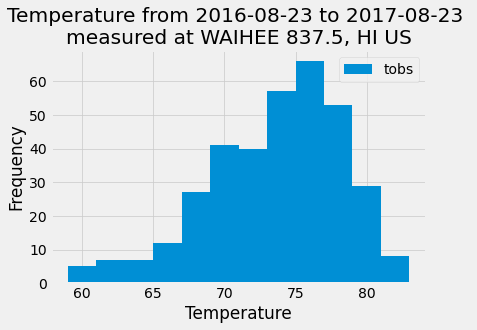

In [53]:
# plotting ths histogram
plt.hist(temps, bins=12, rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title(f"Temperature from {yearb4_lastdate_ts} to {lastdate[0]} \nmeasured at {station_name}")
plt.legend()

## Bonus Challenge Assignment

In [64]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [68]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

prev_year=yearb4_lastdate_ts.year
start_date=str(prev_year)+'-11-20'
end_date=str(prev_year)+'-12-03'
Temp_holiday=calc_temps(start_date, end_date)
Temp_holiday_min=Temp_holiday[0][0]
Temp_holiday_avg=Temp_holiday[0][1]
Temp_holiday_max=Temp_holiday[0][2]

Temp_holiday_error=Temp_holiday_max-Temp_holiday_min

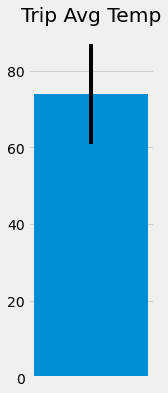

In [69]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.subplots(figsize=(2,6))
plt.bar(1,Temp_holiday_avg,yerr=Temp_holiday_error)
#Removing xticks
plt.xticks([])
plt.title("Trip Avg Temp")
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
